<a href="https://colab.research.google.com/github/CHIN-HUA/AI/blob/main/QPA_code_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import matplotlib.pyplot as plt

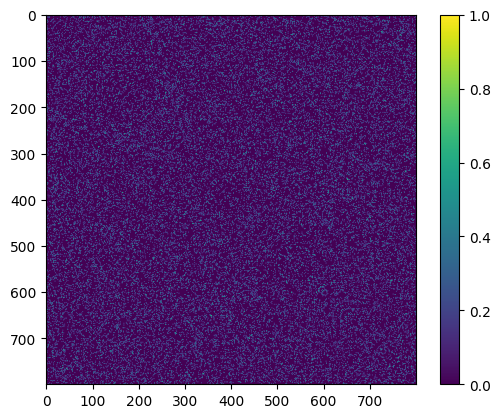

In [89]:
adjMat = np.load("G1.npy")     # load example Max-Cut problem
plt.imshow(adjMat)
plt.colorbar()

# Gset is the benchmark of Max-cut problem which is one of the combinatorial optimization problems.

In [90]:
coulpingMatrix = - adjMat   # Covert problem to Ising coupling

In [91]:
# parameter chosing
numTrials = 100
numIterations = 1000   # predefined number of iterations
numSpins = coulpingMatrix.shape[0]  # number of spins (Problem size N)
adpRate = 0.01    # learning rate/step size
lamda = np.linspace(10,0,numIterations)     # coefficient of initial Hamiltonian

In [92]:
# initilization
spinVector = np.random.randint(2,size=(numSpins,numTrials))*2-1.0   # randomly initialize spin configurations
xVector = np.zeros((numSpins,numTrials))    # zero initialize classical "superposition"
momentum = np.zeros((numSpins,numTrials))    # zero initialize momentum
isingHamil = np.zeros(numTrials)    # Ising Hamiltonian
isingHamilHistory = np.zeros((numIterations,numTrials))     # Ising Hamiltonian History
isingHamilHistory_annealing = np.zeros((numIterations, numTrials))
isingHamilHistory_tide = np.zeros((numIterations, numTrials))

In [93]:
# run
for ii in np.arange(numIterations):
    delHising = np.dot(-coulpingMatrix, spinVector)     # can be implemented experimentally by memristor crossbar array
    delHinit = xVector
    delHsystem = delHising + lamda[ii]*delHinit
    momentum = (1-adpRate)*momentum - adpRate*delHsystem    # update momentum
    momentum = np.clip(momentum,-1,1)   # clip momentum
    xVector += momentum     # update classical "superposition"
    xVector = np.clip(xVector,-1,1 )    # clip classical "superposition"
    spinVector = np.sign(xVector)
    for tt in np.arange(numTrials):
        isingHamil[tt] = - 0.5*np.dot(spinVector[:,tt].T, (coulpingMatrix @ spinVector[:,tt]))      # calculate Ising Hamiltonian
    isingHamilHistory[ii] = isingHamil      # energy tracking

In [94]:
# 模擬退火版本
spinVector = np.random.randint(2, size=(numSpins, numTrials)) * 2 - 1.0
for ii in range(numIterations):
    temperature = lamda[ii]
    for tt in range(numTrials):
        idx = np.random.randint(0, numSpins)
        new_spinVector = spinVector[:, tt].copy()
        new_spinVector[idx] *= -1

        old_energy = -0.5 * np.dot(spinVector[:, tt].T, (coulpingMatrix @ spinVector[:, tt]))
        new_energy = -0.5 * np.dot(new_spinVector.T, (coulpingMatrix @ new_spinVector))
        delta_E = new_energy - old_energy

        if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
            spinVector[:, tt] = new_spinVector

        isingHamil = -0.5 * np.dot(spinVector[:, tt].T, (coulpingMatrix @ spinVector[:, tt]))
        isingHamilHistory_annealing[ii, tt] = isingHamil


<ipython-input-94-38f486f08007>:14: RuntimeWarning: divide by zero encountered in scalar divide
  if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):
<ipython-input-94-38f486f08007>:14: RuntimeWarning: invalid value encountered in scalar divide
  if delta_E < 0 or np.random.rand() < np.exp(-delta_E / temperature):


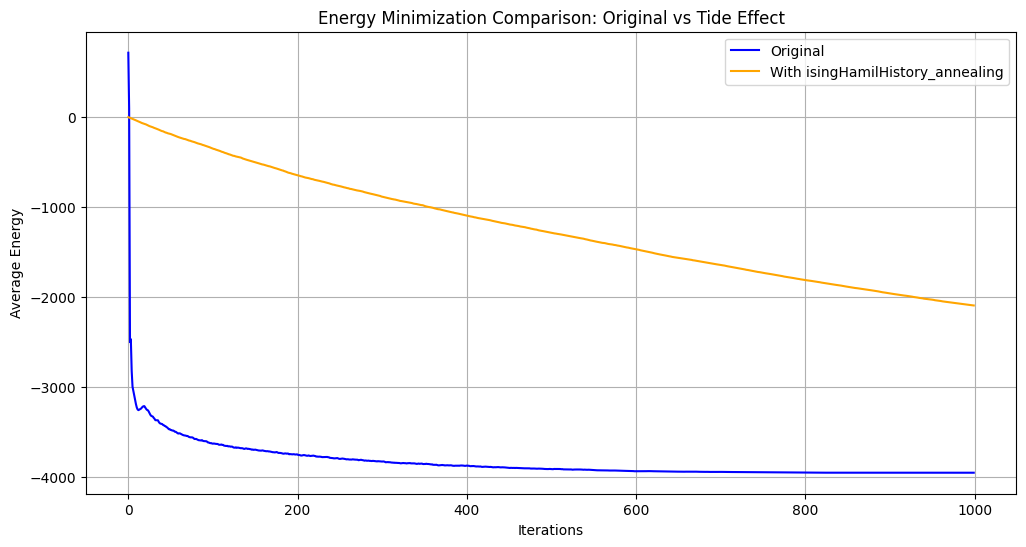

In [95]:
    # 計算平均能量
mean_energy_momentum = np.mean(isingHamilHistory, axis=1)
mean_energy_annealing = np.mean(isingHamilHistory_annealing, axis=1)

# Plot comparison
plt.figure(figsize=(12, 6))

mean_original = isingHamilHistory.mean(axis=1)
mean_tide = isingHamilHistory_annealing.mean(axis=1)

plt.plot(mean_original, label="Original", color='blue')
plt.plot(mean_tide, label="With isingHamilHistory_annealing", color='orange')
plt.title("Energy Minimization Comparison: Original vs Tide Effect")
plt.xlabel("Iterations")
plt.ylabel("Average Energy")
plt.legend()
plt.grid()
plt.show()

In [110]:
import numpy as np
import matplotlib.pyplot as plt


# initilization
spinVector = np.random.randint(2,size=(numSpins,numTrials))*2-1.0   # randomly initialize spin configurations
xVector = np.zeros((numSpins,numTrials))    # zero initialize classical "superposition"
momentum = np.zeros((numSpins,numTrials))    # zero initialize momentum
isingHamil = np.zeros(numTrials)    # Ising Hamiltonian
isingHamilHistory_tide = np.zeros((numIterations, numTrials))



for ii in np.arange(numIterations):
    # 計算 Ising 貢獻
    delHising = np.dot(-coulpingMatrix, spinVector)
    delHinit = xVector

    # 模擬潮汐效應：周期性與衰減結合
    tide_amplitude = np.random.uniform(1.0, 10.0) * np.exp(-ii / (numIterations / 5))

    tide_effect = tide_amplitude * np.sin(2 * np.pi * ii / 100)  # 週期性潮汐
    if (ii % 200) > 100:  # 模擬月亮升起後的緩慢衰減
        tide_effect *= np.cos((ii % 100) * np.pi / 100)

    # 隨機擾動
    random_effect = np.random.randn(*spinVector.shape) * tide_amplitude  # 隨機擾動隨潮汐幅度變化

    # 總能量貢獻
    delHsystem = delHising + lamda[ii] * delHinit + tide_effect + random_effect

    # 動量更新
    momentum =  (1-adpRate) * momentum - adpRate * delHsystem
    momentum = np.clip(momentum, -1, 1)  # 裁剪動量範圍

    # 狀態更新
    xVector += momentum
    xVector = np.clip(xVector, -1, 1)  # 裁剪連續值範圍
    spinVector = np.sign(xVector)  # 更新自旋狀態

    # 計算能量
    for tt in np.arange(numTrials):
      isingHamil[tt] = - 0.5 * np.dot(spinVector[:,tt].T, (coulpingMatrix @ spinVector[:,tt]))

    # 記錄能量歷史
    isingHamilHistory_tide[ii] = isingHamil


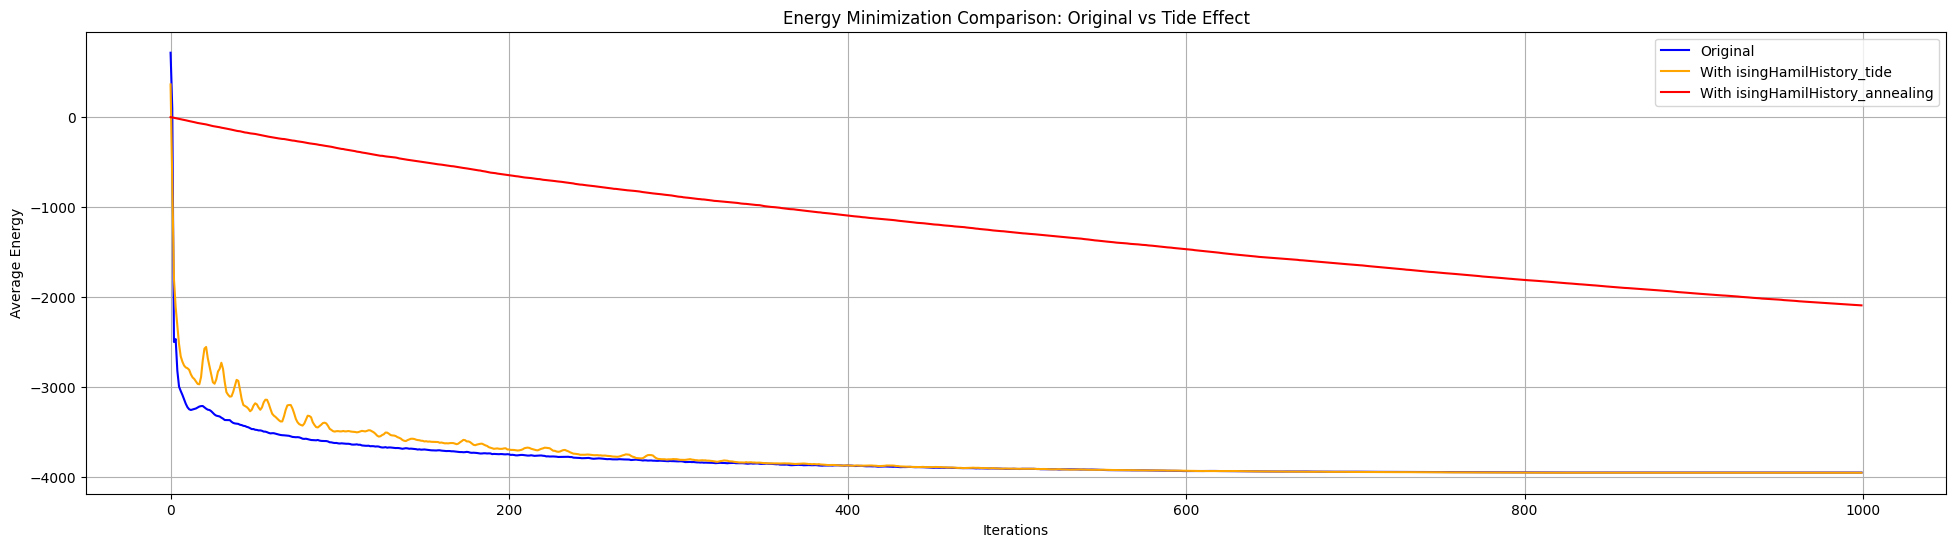

Minimum Energy (Original): -3952.26
Minimum Energy (Tide Effect): -3954.22
Minimum Energy (Annealing): -2094.24


In [111]:
# Plot comparison
plt.figure(figsize=(24, 6))

mean_original = isingHamilHistory.mean(axis=1)
mean_tide = isingHamilHistory_tide.mean(axis=1)
mean_isingHamilHistory_annealing = isingHamilHistory_annealing.mean(axis=1)

plt.plot(mean_original, label="Original", color='blue')
plt.plot(mean_tide, label="With isingHamilHistory_tide", color='orange')
plt.plot(mean_isingHamilHistory_annealing, label="With isingHamilHistory_annealing", color='red')
plt.title("Energy Minimization Comparison: Original vs Tide Effect")
plt.xlabel("Iterations")
plt.ylabel("Average Energy")
plt.legend()
plt.grid()
plt.show()

# Compare minimum values
min_original = mean_original.min()
min_tide = mean_tide.min()
min_annealing = mean_isingHamilHistory_annealing.min()

print(f"Minimum Energy (Original): {min_original}")
print(f"Minimum Energy (Tide Effect): {min_tide}")
print(f"Minimum Energy (Annealing): {min_annealing}")